In [15]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import glob
import sys
import pandas as pd
import itertools
import util
from sklearn.metrics import mean_squared_error

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
labeled = pd.read_csv('labelled.csv')
path_ids = labeled['TSS_index'].values
paths = [f'/shared/shush/results/CREME/greedy_search/pickled_results/{p}.pickle' for p in path_ids]


In [33]:
colors = ['grey', 'green', 'red']
enh_traces = np.empty((len(paths), 40))
criterion = 'enhancers'

for i, pickle_path in enumerate(paths):
    tss_preds = util.dict_load(pickle_path)
    t = [tss_preds['wt_pred'][448]] + [p.mean() for p in tss_preds[f'path_{criterion}']]
    enh_traces[i, :] = t/tss_preds['wt_pred'][448]

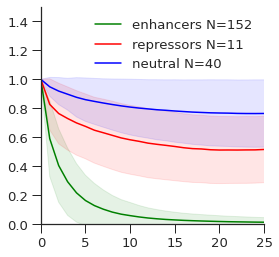

In [34]:
sns.set(font_scale = 1.2)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1, 1, figsize=[4,4])
color_code = {'neutral': 'blue', 'enhancers': 'green', 'repressors': 'red'}

for i, l in enumerate(labeled['context'].unique()):
    ind = np.argwhere(labeled['context'] == l).flatten()
    data = enh_traces[ind]

    mean = data.mean(axis=0)
    std = data.std(axis=0)
    color = color_code[l.split()[0]]
    ax.plot(mean, c=color, alpha=1, label=l)
    ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)
plt.ylim(0,1.5)
plt.xlim(0, 25)
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [35]:
colors = ['grey', 'green', 'red']
enh_traces = np.empty((len(paths), 40))
criterion = 'repressors'

for i, pickle_path in enumerate(paths):
    tss_preds = util.dict_load(pickle_path)
    t = [tss_preds['wt_pred'][448]] + [p.mean() for p in tss_preds[f'path_{criterion}']]
    enh_traces[i, :] = t/tss_preds['wt_pred'][448]

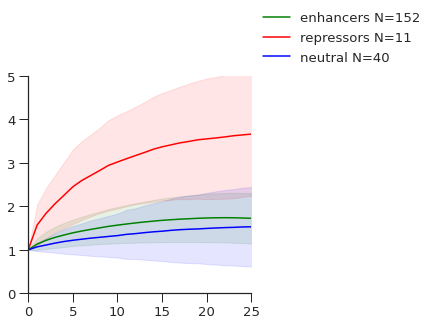

In [36]:
sns.set(font_scale = 1.2)
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

fig, ax = plt.subplots(1, 1, figsize=[4,4])
color_code = {'neutral': 'blue', 'enhancers': 'green', 'repressors': 'red'}

for i, l in enumerate(labeled['context'].unique()):
    ind = np.argwhere(labeled['context'] == l).flatten()
    data = enh_traces[ind]
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    color = color_code[l.split()[0]]
    ax.plot(mean, c=color, alpha=1, label=l)
    ax.fill_between(range(data.shape[1]), mean-std, mean+std, alpha=0.1, color=color)
plt.ylim(0, 5)
plt.xlim(0, 25)
plt.legend(frameon=False, bbox_to_anchor=[1,1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [37]:
enh_region = labeled[labeled['context']=='enhancers N=152']
path_ids = enh_region['TSS_index'].values
paths = [f'/shared/shush/results/CREME/greedy_search/pickled_results/{p}.pickle' for p in path_ids]
len(path_ids)

152

In [38]:
all_traces = np.empty((len(paths), 40))
# all_traces_std = np.empty((len(pickle_paths), 40))
all_hypothetical_traces = np.empty((len(paths), 40))

for i, pickle_path in enumerate(paths):
    tss_preds_greedy = util.dict_load(pickle_path)
    

    wt = tss_preds_greedy['wt_pred'][448]

    criterion = 'enhancers'
    mutant_predictions = tss_preds_greedy[criterion].mean(axis=-1)

    trace = np.array([p.mean() for p in tss_preds_greedy[f'path_{criterion}']]) # greedy search predictions in each step
#     trace_std = np.array([p.std() for p in tss_preds_greedy[f'path_{criterion}']]) 
    all_traces[i] = np.concatenate([[wt], trace]) / wt
#     all_traces_std[i] = trace_std
    
    
    mutant_predictions[:, 19] = np.nan
    tile_removed_order = np.nanargmin(mutant_predictions, axis=-1)

    effect_sizes_first_iter = mutant_predictions[0] - wt

    sorted_effect_first_iter = effect_sizes_first_iter[tile_removed_order]
    sum_of_effects = np.cumsum(sorted_effect_first_iter) 
    hypothetical_trace = wt + sum_of_effects
    all_hypothetical_traces[i] = np.concatenate([[wt], hypothetical_trace]) / wt


In [23]:
point3 = []
point4 = []
sign = []
MSE = []
for trace, hypothetical_trace in zip(all_traces, all_hypothetical_traces):
    MSE.append(mean_squared_error(trace, hypothetical_trace))
    sign.append(trace.mean() - hypothetical_trace.mean())
    point3.append(trace[2] - hypothetical_trace[2])
    point4.append(trace[3] - hypothetical_trace[3])
MSE = np.array(MSE) 

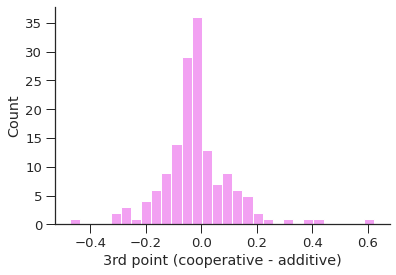

In [24]:
ax = sns.histplot(point3, bins=30, color='violet')
plt.xlabel('3rd point (cooperative - additive)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

In [25]:
len(point3)

152

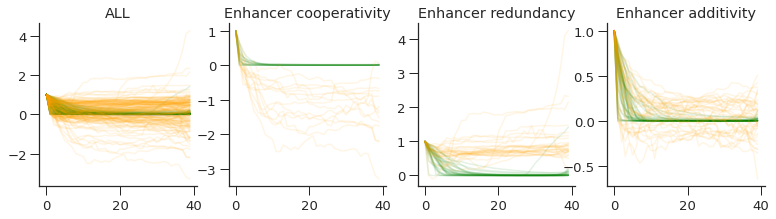

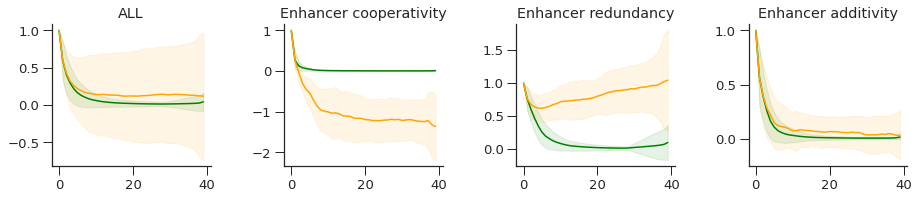

In [26]:
colors = ['green', 'orange']
labels = ['cooperative', 'additive']
titles = ['ALL', 'Enhancer cooperativity', 'Enhancer redundancy', 'Enhancer additivity']
# i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])

pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.3]
neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.3]
zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.05]
all_points = np.arange(len(sign))


for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, x in enumerate([trace_set, hypothetical_trace_set]):
        for t in x:
            
            ax.plot(t, color=colors[i], alpha=.1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            
fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
          
for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, t in enumerate([trace_set, hypothetical_trace_set]):
        t_mean = t.mean(axis=0)
        t_std = t.std(axis=0)
        ax.plot(t_mean, color=colors[i], alpha=1)
    
        ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()

In [27]:
labeled['context'].unique()

array(['enhancers N=152', 'repressors N=11', 'neutral N=40'], dtype=object)

In [28]:
enh_region = labeled[labeled['context']=='repressors N=11']
path_ids = enh_region['TSS_index'].values
paths = [f'/shared/shush/results/greedy_search/pickled_results/{p}.pickle' for p in path_ids]
len(path_ids)

11

In [29]:
all_traces = np.empty((len(paths), 40))
# all_traces_std = np.empty((len(pickle_paths), 40))
all_hypothetical_traces = np.empty((len(paths), 40))

for i, pickle_path in enumerate(paths):
    tss_preds_greedy = util.dict_load(pickle_path)
    

    wt = tss_preds_greedy['wt_pred'][448]

    criterion = 'repressors'
    mutant_predictions = tss_preds_greedy[criterion].mean(axis=-1)

    trace = np.array([p.mean() for p in tss_preds_greedy[f'path_{criterion}']]) # greedy search predictions in each step
#     trace_std = np.array([p.std() for p in tss_preds_greedy[f'path_{criterion}']]) 
    all_traces[i] = np.concatenate([[wt], trace]) / wt
#     all_traces_std[i] = trace_std
    
    
    mutant_predictions[:, 19] = np.nan
    tile_removed_order = np.nanargmin(mutant_predictions, axis=-1)

    effect_sizes_first_iter = wt - mutant_predictions[0]

    sorted_effect_first_iter = effect_sizes_first_iter[tile_removed_order]
    sum_of_effects = np.cumsum(sorted_effect_first_iter) 
    hypothetical_trace = wt + sum_of_effects
    all_hypothetical_traces[i] = np.concatenate([[wt], hypothetical_trace]) / wt


In [30]:
point3 = []
point4 = []
sign = []
MSE = []
for trace, hypothetical_trace in zip(all_traces, all_hypothetical_traces):
    MSE.append(mean_squared_error(trace, hypothetical_trace))
    sign.append(trace.mean() - hypothetical_trace.mean())
    point3.append(trace[2] - hypothetical_trace[2])
    point4.append(trace[3] - hypothetical_trace[3])
MSE = np.array(MSE)

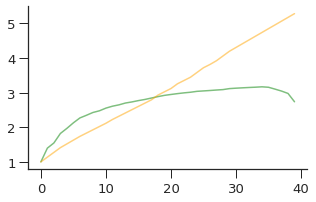

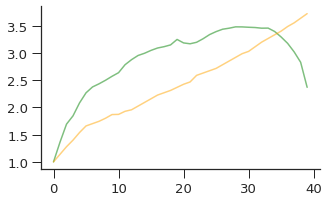

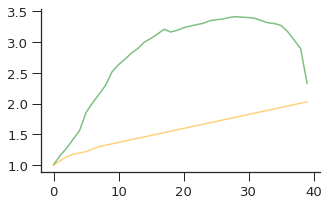

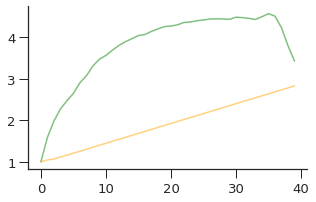

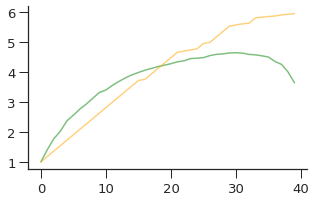

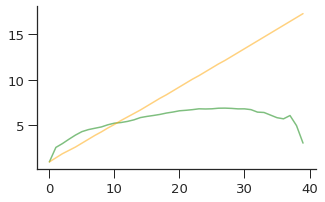

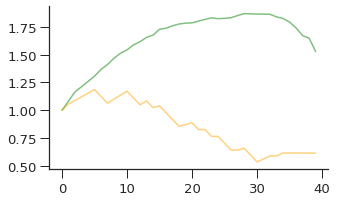

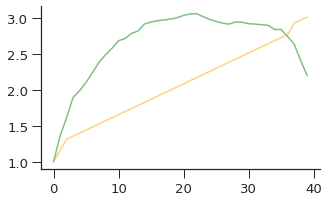

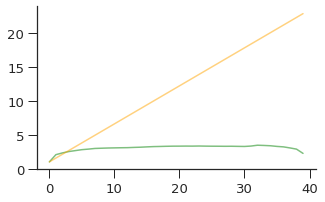

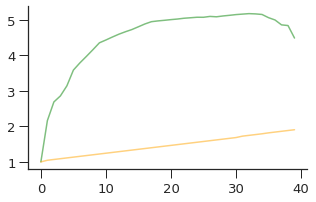

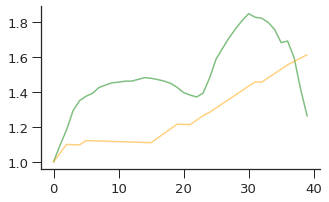

In [31]:

colors = ['green', 'orange']
labels = ['cooperative', 'additive']
# trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
for i, traces in enumerate(zip(all_traces, all_hypothetical_traces)):
    fig, ax = plt.subplots(1, figsize=[5, 3])
    for j, t in enumerate(traces):
        ax.plot(t, color=colors[j], alpha=.5, label=labels[j])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
#     plt.ylim(0,5)
    plt.show()


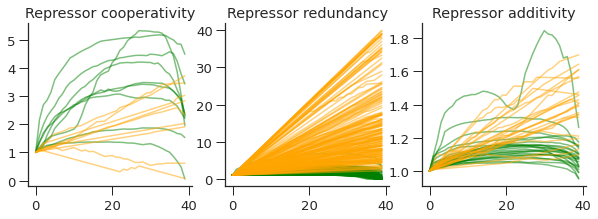

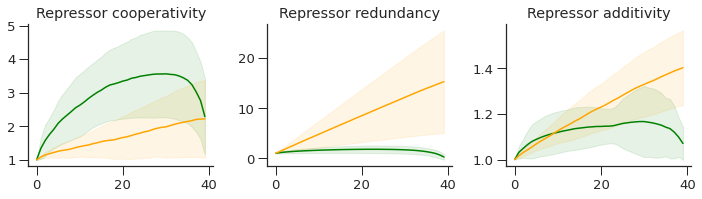

In [117]:
colors = ['green', 'orange']
labels = ['cooperative', 'additive']
titles = ['Repressor cooperativity', 'Repressor redundancy', 'Repressor additivity']
# i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
fig, axes = plt.subplots(1, 3, figsize=[10, 3])

pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.3]
neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.3]
zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.1]

for p, points in enumerate([pos_points, neg_points, zero_points]):
    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, x in enumerate([trace_set, hypothetical_trace_set]):
        for t in x:
            
            ax.plot(t, color=colors[i], alpha=.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            
fig, axes = plt.subplots(1, 3, figsize=[10, 3])
          
for p, points in enumerate([pos_points, neg_points, zero_points]):
    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, t in enumerate([trace_set, hypothetical_trace_set]):
        t_mean = t.mean(axis=0)
        t_std = t.std(axis=0)
        ax.plot(t_mean, color=colors[i], alpha=1)
    
        ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()

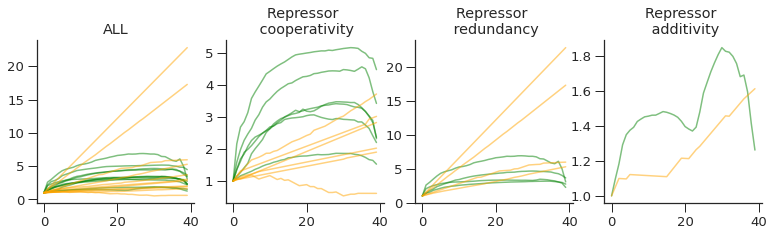

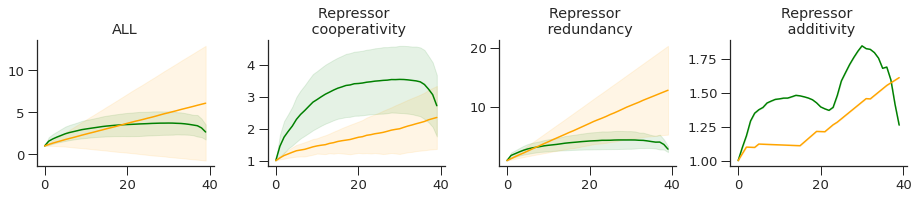

In [181]:
colors = ['green', 'orange']
labels = ['cooperative', 'additive']
titles = ['ALL', 'Repressor \n cooperativity', 'Repressor \n redundancy', 
          'Repressor \n additivity']
# i = np.argwhere(coop).flatten()[np.argmax(MSE[add])]
fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])

pos_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s>0 and m>0.3]
neg_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if s<0 and m>0.3]
zero_points = [j for j, (s, m) in enumerate(zip(sign, MSE)) if m<0.1]
all_points = [j for j, (s, m) in enumerate(zip(sign, MSE))]


for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):
    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, x in enumerate([trace_set, hypothetical_trace_set]):
        for t in x:
            
            ax.plot(t, color=colors[i], alpha=.5)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
            
            
            
fig, axes = plt.subplots(1, len(titles), figsize=[13, 3])
          
for p, points in enumerate([all_points, pos_points, neg_points, zero_points]):

    ax = axes[p]
    ax.set_title(titles[p])
    trace_set, hypothetical_trace_set = all_traces[points], all_hypothetical_traces[points]
    for i, t in enumerate([trace_set, hypothetical_trace_set]):
        t_mean = t.mean(axis=0)
        t_std = t.std(axis=0)
        ax.plot(t_mean, color=colors[i], alpha=1)
    
        ax.fill_between(range(len(t_mean)), t_mean-t_std, t_mean+t_std, alpha=0.1, color=colors[i])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
plt.tight_layout()

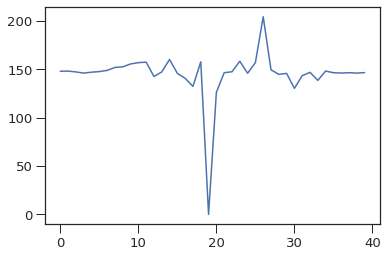

In [191]:
res = util.dict_load(paths[0])
plt.plot(res['repressors'].mean(axis=-1)[0])

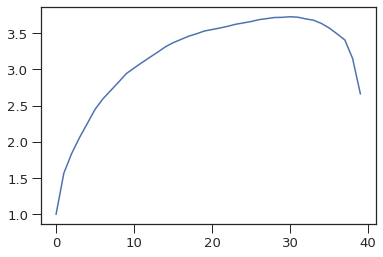

In [197]:
plt.plot(all_traces.mean(axis=0))